In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import dill
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning as L
from collections import OrderedDict

import sys

sys.path.append("../electric-properties-only")
sys.path.append("../end-to-end")
sys.path.append("../end-to-end-with-feedback")
sys.path.append("../../efish-physics-model/objects")
sys.path.append("../../efish-physics-model/helper_functions")
sys.path.append("../../efish-physics-model/uniform_points_generation")

from helpers_conv_nn_models import make_true_vs_predicted_figure
from electric_images_dataset import ElectricImagesDataset
from EndToEndConvNN import EndToEndConvNN
from EndToEndConvNN_PL import EndToEndConvNN_PL
from EndToEndConvNNWithFeedback import EndToEndConvNNWithFeedback
from EndToEndConvNNWithFeedback_PL import EndToEndConvNNWithFeedback_PL

In [3]:
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)

In [4]:
dataset_pd = pd.read_pickle(f"{data_dir_name}/dataset.pkl")

In [5]:
dataset_pd["worms"]["dataframe"].head()

,resistances,capacitances,radii,position_xs,position_ys,position_zs
0,0,0,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,2
3,0,0,0,0,0,3
4,0,0,0,0,0,4


In [6]:
dataset_pd["worms"].keys()

dict_keys(['properties_dict', 'resistances', 'capacitances', 'radii', 'position_xs', 'position_ys', 'position_zs', 'dataframe'])

In [7]:
dataset_pd["worms"]["position_xs"][3]

-0.02

In [8]:
dataset_pd["worms"]["position_zs"][5]

0.0

In [9]:
dataset_pd["worms"]["position_ys"][0]

0.019000000000000003

In [10]:
dataset_pd["worms"]["radii"][13]

0.0075

In [11]:
dataset_pd["worms"]["dataframe"][
    (dataset_pd["worms"]["dataframe"]["position_xs"] == 3) & (dataset_pd["worms"]["dataframe"]["position_zs"] == 5)
].shape

(159600, 6)

In [12]:
temp_features_ids = [
    dataset_pd["worms"]["dataframe"][
        (dataset_pd["worms"]["dataframe"]["position_xs"] == 3)
        & (dataset_pd["worms"]["dataframe"]["position_ys"] == 0)
        & (dataset_pd["worms"]["dataframe"]["position_zs"] == 5)
        & (dataset_pd["worms"]["dataframe"]["radii"] == 13)
    ].index.to_numpy(),
    dataset_pd["worms"]["dataframe"][
        (dataset_pd["worms"]["dataframe"]["position_xs"] == 3)
        & (dataset_pd["worms"]["dataframe"]["position_ys"] == 1)
        & (dataset_pd["worms"]["dataframe"]["position_zs"] == 5)
        & (dataset_pd["worms"]["dataframe"]["radii"] == 13)
    ].index.to_numpy(),
    dataset_pd["worms"]["dataframe"][
        (dataset_pd["worms"]["dataframe"]["position_xs"] == 3)
        & (dataset_pd["worms"]["dataframe"]["position_ys"] == 1)
        & (dataset_pd["worms"]["dataframe"]["position_zs"] == 5)
        & (dataset_pd["worms"]["dataframe"]["radii"] == 8)
    ].index.to_numpy(),
]

In [13]:
temp_features = []
for temp_feat_ids in temp_features_ids:
    temp_features.append([])
    for i in temp_feat_ids:
        electric_image = dset[i][0]
        # print(np.abs(electric_image[0]).argmax(), np.abs(electric_image[1]).argmax())
        temp = [
            electric_image[0].reshape(-1)[np.abs(electric_image[0]).argmax()],
            electric_image[1].reshape(-1)[np.abs(electric_image[1]).argmax()],
        ]
        temp_features[-1].append(temp)
    temp_features[-1] = np.array(temp_features[-1])

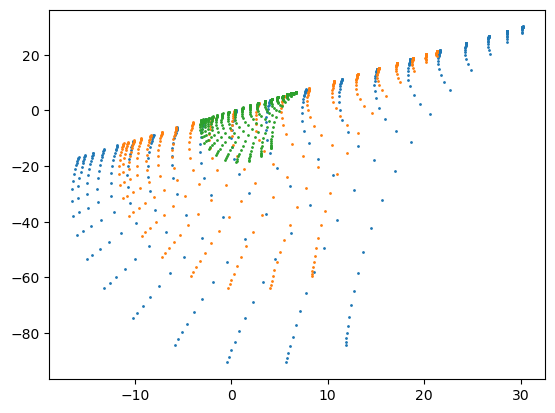

In [14]:
for temp_feats in temp_features:
    plt.scatter(*temp_feats.T, s=1)
plt.show()

## Check that conv_pooling_kernel of size 1 results in original array

In [15]:
in_channels = dset[0][0].shape[0]
kernel_size = 1
electric_images = torch.stack([torch.tensor(dset[i][0]) for i in range(10)])
average_pooling_kernel = (
    torch.ones([in_channels, 1, kernel_size, kernel_size])
    / torch.ones([in_channels, 1, kernel_size, kernel_size]).sum() * 2
)
temp = nn.functional.conv2d(electric_images, average_pooling_kernel, groups=in_channels)

In [16]:
electric_images.shape, temp.shape

(torch.Size([10, 2, 20, 30]), torch.Size([10, 2, 20, 30]))

In [17]:
(electric_images == temp).all()

tensor(True)

# True vs. Predicted Example Panel

In [18]:
from electric_properties_models_dataset import ElectricPropertiesModelsDataset  # noqa: E402
from ElectricPropertiesNN_PL import ElectricPropertiesNN_PL

rc_only_dset = ElectricPropertiesModelsDataset(data_dir_name="../electric-properties-only/")

model = ElectricPropertiesNN_PL.load_from_checkpoint("../electric-properties-only/both_variable/lightning_logs/version_0/checkpoints/epoch=49-step=6750.ckpt")
model.eval()
model.freeze()
model.cpu()

# data loaders
train_dset, valid_dset = torch.utils.data.random_split(rc_only_dset, [0.85, 0.15])  # type: ignore
train_loader = DataLoader(train_dset, batch_size=400, shuffle=True, drop_last=True, num_workers=12)
valid_loader = DataLoader(valid_dset, batch_size=400, shuffle=False, drop_last=True, num_workers=12)

In [32]:
def make_true_vs_predicted_figure(
    true_vals: np.ndarray,
    pred_vals: np.ndarray,
    feature_names: list[str] = ["resistances", "capacitances"],
    title_names: list[str] = [
        "Resistance (log)",
        "Capacitance (log)",
    ],
) -> plt.Figure:  # type: ignore
    """Create a figure comparing the true and predicted values for each feature.

    Args:
        true_vals (np.ndarray): True values.
        pred_vals (np.ndarray): Predicted values.
        feature_names (list[str], optional): Names of the features in the columns of the values.
            Defaults to ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"].

    Returns:
        plt.figure.Figure: Figure object containing the comparison.
    """

    fig, ax = plt.subplots(1, true_vals.shape[-1], figsize=(3 * true_vals.shape[-1], 3))
    for i in range(true_vals.shape[-1]):
        feat_mean = dset.worms_properties_stats[feature_names[i]]["mean"]
        feat_std = dset.worms_properties_stats[feature_names[i]]["std"]

        true_vs = true_vals[:, i] * feat_std + feat_mean
        pred_vs = pred_vals[:, i] * feat_std + feat_mean
        ax[i].scatter(true_vs, pred_vs, c="k", s=20, alpha=1, marker="o", linewidths=0)
        ax[i].plot([true_vs.min(), true_vs.max()], [true_vs.min(), true_vs.max()], ls="--", c="k", lw=1)
        # ax[i].set_xlabel("True", fontsize=12)
        # if i == 0:
        #     ax[i].set_ylabel("Predicted", fontsize=12)
        ax[i].set_title(title_names[i], fontsize=13)
        # ax[i].set_title(f"{title_names[i]}\n$R^2$ = {r2_score(true_vs, pred_vs):.3f}", fontsize=10)
        ax[i].tick_params(axis="both", which="major", labelsize=12)
        ax[i].set_yticks(ax[i].get_xticks())
        ax[i].axis("equal")
        sns.despine(ax=ax[i], offset=dict(left=-20, bottom=-10), trim=True)
    plt.tight_layout()
    return fig

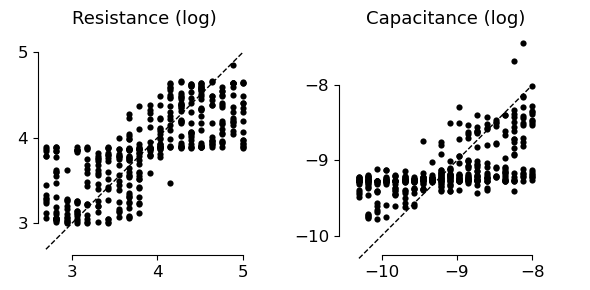

In [33]:
my_batch = next(iter(valid_loader))
my_x = my_batch[0]
my_y = my_batch[1]
my_y_hat = model.model(my_x, distances=my_y[:, 1], radii=my_y[:, 3])
my_y = my_y[:, -2:]

fig = make_true_vs_predicted_figure(my_y.detach().numpy()[:400], my_y_hat.detach().numpy()[:400])

plt.savefig("true_vs_predicted-rc_only.svg")
plt.show()